# 资产组合构建

## 本段代码利用quantOS系统进行资产分析及组合构建，并通过比较沪深300指数波动率及其成分
## 股波动率中位数，说明组合的作用 

## 1. 根据资产性质组合中债指数，沪深300全收益指数以及阿尔法指数
## 2. 比较沪深300指数波动率及成份股波动率中位数

## 系统设置

In [1]:
# encoding: utf-8
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import matplotlib.mlab as mlab
import scipy.stats as stats

sns.set_style('darkgrid')
sns.set_context('poster')
%matplotlib inline

In [2]:
from jaqs.data import RemoteDataService
import jaqs.util as jutil
from __future__ import print_function, unicode_literals, division, absolute_import

from jaqs.data import RemoteDataService, DataView

In [3]:
dataview_dir_path = '.'
backtest_result_dir_path = '.'

import os
phone = os.environ.get('QUANTOS_USER')
token = os.environ.get('QUANTOS_TOKEN')

data_config = {
  "remote.data.address": "tcp://data.quantos.org:8910",
  "remote.data.username": phone,
  "timeout": 3600,
  "remote.data.password": token
}

ds = RemoteDataService()
ds.init_from_config(data_config)


Begin: DataApi login 17321165656@tcp://data.quantos.org:8910
    login success 



'0,'

## 1. 根据资产性质进行大类资产配置

## 导入收益率数据文件

In [4]:
df = pd.read_csv('data.csv')

In [5]:
df = df.set_index('date')

In [6]:
df.index = [pd.Timestamp(str(x)) for x in df.index]

In [7]:
print('三个标的年化波动率为(%)：')
print(np.std(df[['bond', 'alpha', '300']]) * np.sqrt(242) * 100)

三个标的年化波动率为(%)：
bond      1.235005
alpha    17.597373
300      25.981319
dtype: float64


## 设置权重，并计算每日组合收益率

In [8]:
annual_std = np.std(df[['bond', 'alpha', '300']]) * np.sqrt(242) * 100
weight = np.array(1.0/np.sum(1.0/annual_std)*(1.0/annual_std))
weight = np.array([0.6, 0.2,0.2])

In [9]:
df['Combined'] = df.multiply(weight, axis = 1).sum(axis = 1)

## 计算每个组合累积收益率

In [10]:
df['cum_bond'] = (1 + df['bond']).cumprod()
df['cum_alpha'] =(1 + df['alpha']).cumprod()
df['cum_hs300'] = (1 + df['300']).cumprod()
df['cum_weighted'] = (1 + df['Combined']).cumprod()
# df *= 100

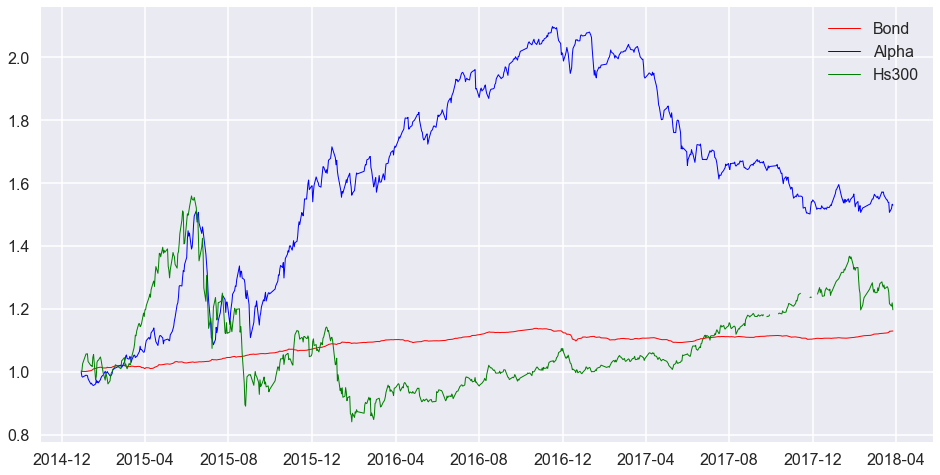

In [11]:
fig, ax = plt.subplots(figsize = (16,8))
plt.plot(df.index, df.cum_bond, lw = 1, color = 'red', label = 'Bond')
plt.plot(df.index, df.cum_alpha, lw = 1, color = 'blue', label = 'Alpha')
plt.plot(df.index, df.cum_hs300, lw = 1, color = 'green', label = 'Hs300')
plt.legend()

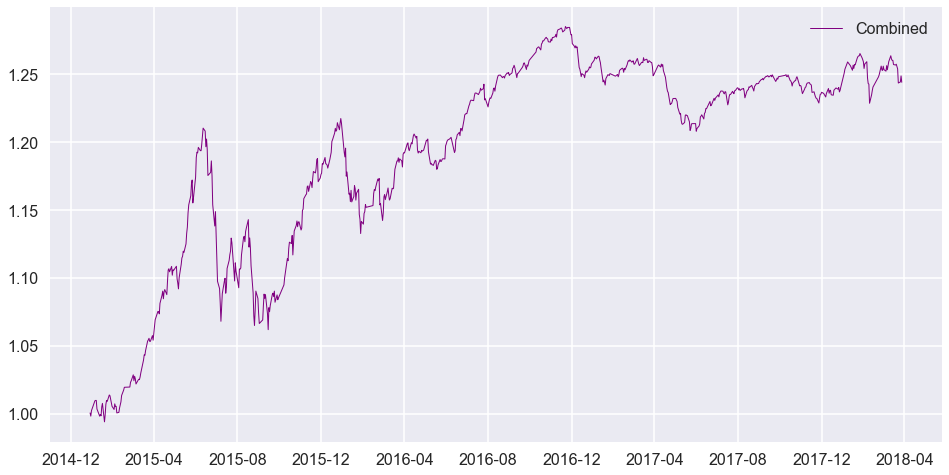

In [12]:
fig, ax = plt.subplots(figsize = (16,8))
plt.plot(df.index, df.cum_weighted, lw = 1, color = 'purple', label = 'Combined')
plt.legend()

## 计算各标的收益率指标

In [13]:
print('各标的年化收益率为(%)：')
print(np.mean(df[['bond', 'alpha', '300', 'Combined']]) * 242 * 100)

各标的年化收益率为(%)：
bond         3.769510
alpha       14.670861
300          9.092818
Combined     6.975059
dtype: float64


In [14]:
print('各个标的年化波动率为(%)：')
print(np.std(df[['bond', 'alpha', '300', 'Combined']]) * np.sqrt(242) * 100)

各个标的年化波动率为(%)：
bond         1.235005
alpha       17.597373
300         25.981319
Combined     6.972358
dtype: float64


In [15]:
risk_free_rate = 0.03 / 242  
print('各个标的年化Sharpe Ratio为(%)：')
print(np.mean(df[['bond', 'alpha', '300', 'Combined']] - risk_free_rate)/np.std(df[['bond', 'alpha', '300', 'Combined']]) * np.sqrt(242))

各个标的年化Sharpe Ratio为(%)：
bond        0.623083
alpha       0.663216
300         0.234508
Combined    0.570117
dtype: float64


## 计算correlation

In [16]:
df[['bond', 'alpha', '300', 'Combined']].corr()

,bond,alpha,300,Combined
bond,1.000000,-0.035121,0.001408,0.089642
alpha,-0.035121,1.000000,0.261822,0.693250
300,0.001408,0.261822,1.000000,0.869959
Combined,0.089642,0.693250,0.869959,1.000000


# 2. 沪深300成份股年化波动率 

In [17]:
START_DATE, END_DATE = 20160101, 20180328
UNIVERSE = '000300.SH'

In [18]:
dataview_props = {# Start and end date of back-test
                  'start_date': START_DATE, 'end_date': END_DATE,
                  # Investment universe and performance benchmark
                  'universe': UNIVERSE, 'benchmark': UNIVERSE,
                  # Data fields that we need
                  'fields': 'free_share,total_share,float_share,float_mv,sw1',
                  # freq = 1 means we use daily data. Please do not change this.
                  'freq': 1}

# DataView utilizes RemoteDataService to get various data and store them
dv = DataView()
dv.init_from_config(dataview_props, ds)
dv.prepare_data()

Initialize config success.
Query data...
Query data - query...
NOTE: price adjust method is [post adjust]
238
477
238
477
46
93
140
187
234
281
328
375
422
469
516
563
    At fields 
Query data - daily fields prepared.
Query instrument info...
Query adj_factor...
Query benchmark...
Query benchmar member info...
Query groups (industry)...
Data has been successfully prepared.


## 计算个股日收益率及相应波动率

In [19]:
dv.add_formula('daily_ret', 'Return(close_adj, 1)', is_quarterly = False)
daily_ret = dv.get_ts('daily_ret')
daily_std = np.std(daily_ret, axis = 0) * np.sqrt(242)
daily_std = daily_std.dropna()

In [20]:
print('沪深300成份股年化波动率中位数为: %.3f' % np.median(daily_std))
print('沪深300成份股年化波动率0.25分位数为: %.3f' % np.percentile(daily_std, 25))
print('沪深300成份股年化波动率0.75分位数为: %.3f' % np.percentile(daily_std, 75))

沪深300成份股年化波动率中位数为: 0.332
沪深300成份股年化波动率0.25分位数为: 0.285
沪深300成份股年化波动率0.75分位数为: 0.393


## 计算指数日收益率及相应波动率 

In [21]:
benchmark_ret = (dv.data_benchmark.diff()/dv.data_benchmark.shift(1)).dropna().values
benchmark_std = np.std(benchmark_ret) * np.sqrt(242)

In [22]:
print('沪深300指数年化波动率为: %.3f' % benchmark_std)

沪深300指数年化波动率为: 0.176


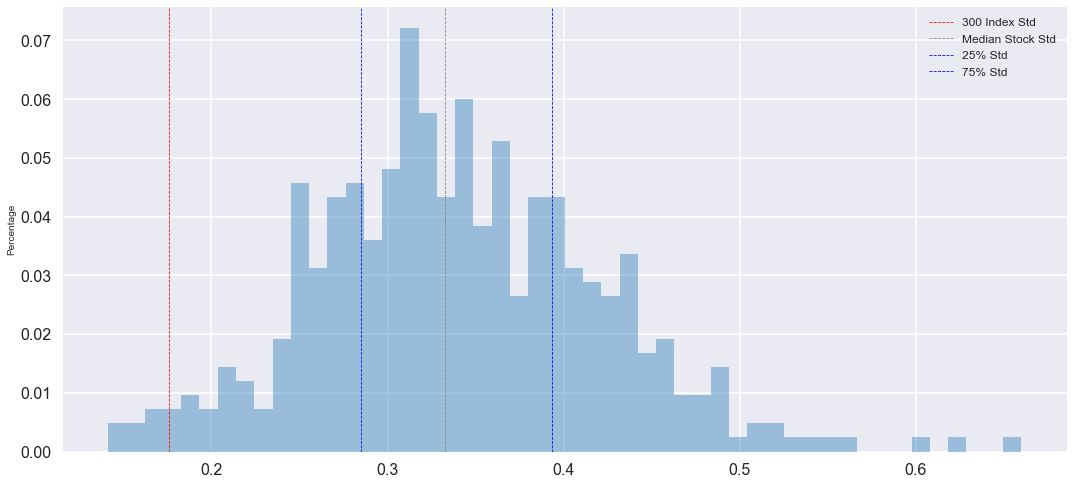

In [23]:
fig = plt.figure(figsize=(18,18))
v = daily_std.values
avgRet = np.median(v)
pct_25 = np.percentile(daily_std, 25)
pct_75 = np.percentile(daily_std, 75)
stdRet = np.std(v)
x = np.linspace(avgRet - 3*stdRet, avgRet + 3*stdRet, 100)
y = mlab.normpdf(x, avgRet, stdRet)
kde = stats.gaussian_kde(v)

# plot the histogram
plt.subplot(211)
plt.hist(v, 50, weights = np.ones(len(v))/len(v), alpha = 0.4)
plt.axvline(x = benchmark_std, color = 'red', linestyle = '--', linewidth = 0.8, label = '300 Index Std')
plt.axvline(x = avgRet, color = 'grey', linestyle = '--', linewidth = 0.8, label = 'Median Stock Std')
plt.axvline(x = pct_25, color = 'blue', linestyle = '--', linewidth = 0.8, label = '25% Std')
plt.axvline(x = pct_75, color = 'blue', linestyle = '--', linewidth = 0.8, label = '75% Std')
plt.ylabel('Percentage', fontsize = 10)
plt.legend(fontsize = 12)